[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kargenk/oreilly-style_transfer/blob/master/notes/style_transfer_for_Colab.ipynb)

In [0]:
# GoogleDriveマウント用パッケージ
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [0]:
# Googledriveへのアクセス許可(トークン)
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

In [0]:
# アクセス許可(2)
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# Google drive の特定フォルダのみマウント
# root_folder= はマウントしたいフォルダのURLの末尾
!cp -f ~/.gdfuse/default/config config
!sed -i -e "s/^root_folder=$/root_folder=" config

!mkdir -p drive
!google-drive-ocamlfuse -config ./config -cc drive
!ls drive

In [0]:
# ファイルのダウンロード

# id = '13d3zUWgJaf4LDZePpmgBt62qLCwsrafu'  # 共有リンクで取得した id= より後の部分
# downloaded = drive.CreateFile({'id': id})
# downloaded.GetContentFile('zunda.JPG')

# id = '1TGYPaH68NhqnszSGEDoOJ7TGWpOodBmJ'
# downloaded = drive.CreateFile({'id': id})
# downloaded.GetContentFile('IMG_9694.JPG')

# lsで確認
!ls

In [6]:
# 上部メニューのランタイム -> ランタイプのタイプ変更からGPUを選択
# GPUが正しくアサインされているか確認
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import os
import sys
import scipy.io
import scipy.misc
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# A5サイズ(300dpi)
# IMAGE_HEIGHT = 2480
# IMAGE_WIDTH = 1748

IMAGE_HEIGHT = 500
IMAGE_WIDTH = 548
IMAGE_CHANNEL = 3

# imagenetの訓練データの平均画素値
IMAGENET_MEAN = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

In [0]:
# vgg-19の各層の重みとバイアスを取得
def get_vgg_weight_bias(vgg_layers, n):
    weights_bias = vgg_layers[0][n][0][0][2]
    weights = weights_bias[0][0]
    bias = weights_bias[0][1]
    #layer_name = vgg_layers[0][n][0][0][0][0]
    
    W = tf.constant(weights)
    b = tf.constant(np.reshape(bias, (bias.size)))
    return W, b

In [0]:
# 畳み込み層
def conv2d(x, Wb=None, stride=1, relu=True):
    net = tf.nn.conv2d(x,
                       filter=Wb[0],
                       strides=[1, stride, stride, 1],
                       padding='SAME') + Wb[1]
    if relu:
        return tf.nn.relu(net)
    return net

In [0]:
# プーリング層(アベレージ)
def avg_pool(x, ksize=2, stride=2):
    net = tf.nn.avg_pool(x,
                         ksize=[1, ksize, ksize, 1],
                         strides=[1, stride, stride, 1],
                         padding='SAME')
    return net

In [0]:
def model():
    vgg = scipy.io.loadmat("drive/imagenet-vgg-verydeep-19.mat") # vggの読み込み
    vgg_layers = vgg['layers']
    
    net = {}
    net['input'] = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)).astype('float32'))
    net['conv1_1'] = conv2d(net['input'], get_vgg_weight_bias(vgg_layers, 0))
    net['conv1_2'] = conv2d(net['conv1_1'], get_vgg_weight_bias(vgg_layers, 2))
    net['avg-pool1'] = avg_pool(net['conv1_2'])
    net['conv2_1'] = conv2d(net['avg-pool1'], get_vgg_weight_bias(vgg_layers, 5))
    net['conv2_2'] = conv2d(net['conv2_1'], get_vgg_weight_bias(vgg_layers, 7))
    net['avg-pool2'] = avg_pool(net['conv2_2'])
    net['conv3_1'] = conv2d(net['avg-pool2'], get_vgg_weight_bias(vgg_layers, 10))
    net['conv3_2'] = conv2d(net['conv3_1'], get_vgg_weight_bias(vgg_layers, 12))
    net['conv3_3'] = conv2d(net['conv3_2'], get_vgg_weight_bias(vgg_layers, 14))
    net['conv3_4'] = conv2d(net['conv3_3'], get_vgg_weight_bias(vgg_layers, 16))
    net['avg-pool3'] = avg_pool(net['conv3_4'])
    net['conv4_1'] = conv2d(net['avg-pool3'], get_vgg_weight_bias(vgg_layers, 19))
    net['conv4_2'] = conv2d(net['conv4_1'], get_vgg_weight_bias(vgg_layers, 21))
    net['conv4_3'] = conv2d(net['conv4_2'], get_vgg_weight_bias(vgg_layers, 23))
    net['conv4_4'] = conv2d(net['conv4_3'], get_vgg_weight_bias(vgg_layers, 25))
    net['avg-pool4'] = avg_pool(net['conv4_4'])
    net['conv5_1'] = conv2d(net['avg-pool4'], get_vgg_weight_bias(vgg_layers, 28))
    net['conv5_2'] = conv2d(net['conv5_1'], get_vgg_weight_bias(vgg_layers, 30))
    net['conv5_3'] = conv2d(net['conv5_2'], get_vgg_weight_bias(vgg_layers, 32))
    net['conv5_4'] = conv2d(net['conv5_3'], get_vgg_weight_bias(vgg_layers, 34))
    net['avg-pool5'] = avg_pool(net['conv5_4'])
    return net

コンテンツ画像のコスト関数
$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2 $$

In [0]:
# コンテンツ画像と生成画像の誤差
def compute_content_cost(a_C, a_G):
    
    # 隠れ層の生成画像の各次元を行ベクトルで取得
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # 列ベクトルに変換
    a_C_unrolled = tf.transpose(a_C)
    a_G_unrolled = tf.transpose(a_G)
    
    # コストの計算
    J_content = (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.pow((a_C_unrolled - a_G_unrolled), 2))
    
    return J_content

スタイル画像のコスト関数
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2 $$

In [0]:
# グラム行列の生成
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [0]:
# 各層のスタイル画像のコスト関数
def compute_layer_style_cost(a_S, a_G):
    
    # 隠れ層の生成画像の各次元を行ベクトルで取得
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # 各画像を(n_C, n_H*n_W)にリシェイプ
    a_S = tf.reshape(tf.transpose(a_S, [0,3,1,2]), [n_C, n_H*n_W])
    a_G = tf.reshape(tf.transpose(a_G, [0,3,1,2]), [n_C, n_H*n_W])
    
    # 各画像のグラム行列を計算
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    # コストを計算
    J_style_layer = tf.reduce_sum(tf.squared_difference(GS, GG) / (4 * (n_C**2) * (n_H*n_W)**2))
    
    return J_style_layer

スタイル画像のコスト関数の結合
$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

In [0]:
# スタイル画像と生成画像で誤差をとる層(任意)
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)
]

In [0]:
# スタイル画像と生成画像の誤差
def compute_style_cost(model, STYLE_LAYERS):
    
    # スタイルコストの初期化
    J_style = 0
    
    for layer_name, coeff in STYLE_LAYERS:
        # 出力先の指定
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        
        # 現在の層のスタイルコストを計算
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        
        # coeff:係数λを用いて，全体のスタイルコストを計算
        J_style += coeff * J_style_layer
    return J_style

トータルコスト関数
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [0]:
# トータルコスト関数
def total_cost(J_content, J_style, alpha=10, beta=40):
    J = alpha * J_content + beta * J_style
    return J

In [0]:
# 画像の読み込み
def reshape_and_normalize_image(image):
    
    # [width, height, channel]を[1, width, height, channel]にリシェイプ
    image = np.reshape(image, ((1,) + image.shape))
    
    # imagenet-vgg-verydeep-19はimagenetを訓練データにしており，
    # 平均値をゼロにするため，imagenetの平均画素値である[123.68, 116.779, 103.939]
    # を引く必要がある(前処理)
    image = image - IMAGENET_MEAN
    
    return image

In [0]:
# 画像の保存
def save_image(path, image):
    # 前処理で正規化したものを元に戻す
    image = image + IMAGENET_MEAN
    
    # 範囲外の値ならmin/Maxにクリッピング
    image = np.clip(image[0], 0, 255).astype('uint8')
    
    # 保存
    scipy.misc.imsave(path, image)
    #Image.fromarray(image).save('path')

In [0]:
# ホワイトノイズの生成
def generate_noise_image(content_image, noise_ratio=0.7):
    
    # ランダムなノイズ画像を生成
    noise_image = np.random.uniform(-20, 20, (1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL)).astype('float32')
    
    # コンテンツ画像とホワイトノイズ画像を合成した画像を生成
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

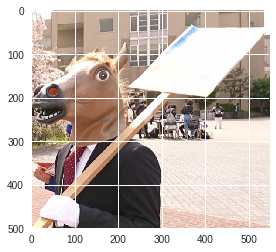

In [22]:
content_image = Image.open("drive/uma.png")
plt.imshow(content_image)
plt.show()

content_image = scipy.misc.imread("drive/uma.png")
content_image = reshape_and_normalize_image(content_image)

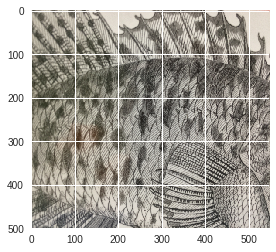

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [23]:
style_image = Image.open("drive/zerotuku01.JPG")
# スタイル画像をコンテンツ画像のサイズにリサイズ
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
plt.imshow(style_image)
plt.show()

style_image = scipy.misc.imread("drive/zerotuku01.JPG")
# スタイル画像をコンテンツ画像のサイズにリサイズ
style_image = scipy.misc.imresize(style_image, (IMAGE_HEIGHT, IMAGE_WIDTH))
style_image = reshape_and_normalize_image(style_image)

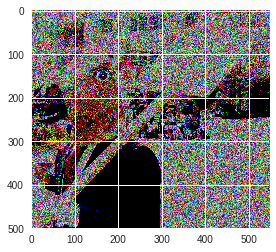

In [24]:
# ホワイトノイズ画像の生成
generated_image = generate_noise_image(content_image)
plt.imshow(np.clip(generated_image[0], 0, 255))

In [0]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [0]:
# 初期化
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [0]:
# vgg-19モデルのロード
net = model()

In [0]:
# vggのinput層にコンテンツ画像を入れる
sess.run(net['input'].assign(content_image))

# 誤差をとる層の選択
out = net['conv4_2']
a_C = sess.run(out)
a_G = out

# コンテンツコストの計算
J_content = compute_content_cost(a_C, a_G)

In [0]:
# vggのinput層にスタイル画像を入れる
sess.run(net['input'].assign(style_image))

# スタイルコストの計算
J_style = compute_style_cost(net, STYLE_LAYERS)

In [0]:
# 全体のコスト関数の計算
J_total = total_cost(J_content, J_style)
optimizer = tf.train.AdamOptimizer(2.0)

In [31]:
# コスト関数の最小化
train = optimizer.minimize(J_total)
sess.run(tf.global_variables_initializer())
sess.run(net['input'].assign(generated_image))

array([[[[26.362757, 27.466421, 37.325   ],
         [38.11796 , 38.661007, 30.15526 ],
         [38.192753, 47.18829 , 36.07793 ],
         ...,
         [44.423363, 48.93017 , 40.392483],
         [52.550667, 46.9807  , 55.258533],
         [49.76067 , 28.591175, 48.129524]],

        [[24.75663 , 44.604183, 31.13808 ],
         [36.059624, 32.602364, 41.163532],
         [43.35099 , 40.99558 , 33.656235],
         ...,
         [42.071842, 40.421642, 55.672283],
         [32.175323, 46.88151 , 57.847122],
         [36.15313 , 30.100721, 46.137676]],

        [[50.94075 , 29.483082, 30.868029],
         [38.284653, 37.51609 , 36.585533],
         [43.908825, 42.82037 , 48.568428],
         ...,
         [45.40634 , 33.665363, 54.399784],
         [33.662006, 44.5408  , 41.458916],
         [37.925896, 44.4033  , 54.25578 ]],

        ...,

        [[29.440907, 15.663195, 20.479452],
         [23.531649, 19.21653 , 22.996614],
         [33.696285, 30.58931 , 38.58718 ],
         ...,


In [0]:
# 生成画像の保存先ディレクトリとベース名
OUTPUT_DIR = "drive/zerotuku01_uma"
OUTPUT_IMG = "result.png"

# 保存先ディレクトリがない場合は作成
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [0]:
for i in range(5000):
    sess.run(train)
    
    # 100回ごとに経過を表示，画像を生成
    if i % 100 == 0:
        result_img = sess.run(net['input'])
        print("iteration: ", i, ", cost: ", sess.run(J_total))
        save_image(os.path.join(OUTPUT_DIR,'%s.png'%(str(i).zfill(4))), result_img)